# TP2

## Exercise 1 : Data set contaminated

### Q1

In [292]:
#%matplotlib inline
from scipy.stats import t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [293]:
data = pd.read_csv("./data_dm3.csv", sep = ",", header = None)

In [294]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,-1.298173,-0.162249,1.223379,1.355554,1.080171,0.634979,0.298741,0.548270,0.731773,1.018645,...,0.588278,0.210106,1.861458,-0.436399,0.279299,-1.416020,-2.332363,0.215096,-0.693319,151.0
1,0.166951,-0.338060,-0.618867,0.759366,1.134281,-0.536844,-0.075120,0.970251,-0.327487,0.717310,...,-0.251054,-0.825716,0.339139,1.119430,0.225958,-0.822288,0.382838,-0.718829,-0.188993,75.0
2,-0.416177,-0.205659,-1.282226,1.675500,1.523746,0.192029,-0.235840,-1.954626,-0.853309,0.892791,...,1.283837,0.372516,-0.652557,-2.579347,0.139267,-1.901196,0.048210,0.220205,0.471588,141.0
3,0.867184,-0.398667,0.093501,0.025971,1.852099,0.789774,0.801775,0.376711,0.853689,0.247953,...,0.446582,0.334733,0.399074,-0.884172,0.723819,1.316367,0.088218,0.619496,1.061662,206.0
4,1.193282,-0.936980,-0.725039,0.766078,0.223489,-1.584622,1.146866,0.086136,-0.088780,-0.945066,...,0.786157,-1.058179,-0.155788,-0.642504,2.040010,-1.703110,-1.901502,1.778811,-0.489853,135.0


In [295]:
print("Number of exploratory variables :", data.shape[1]-1)
print("Number of observations :", data.shape[0])

Number of exploratory variables : 210
Number of observations : 442


### Q2

In [296]:
covariates = data[data.columns[0:data.shape[1]-1]]
scores = data[data.columns[-1]]

for d in covariates:
    assert covariates[d].mean() < 0.001
    assert covariates[d].mean() - 1 < 0.001

All the exploratory variables are centered and normalized.

In [297]:
print("Output mean :", scores.mean())
print("Output std :", scores.std())

Output mean : 152.13348416289594
Output std : 77.09300453299109


The output variable is neither centered nor normalized.

In [298]:
import seaborn as sb
from numpy.random import choice

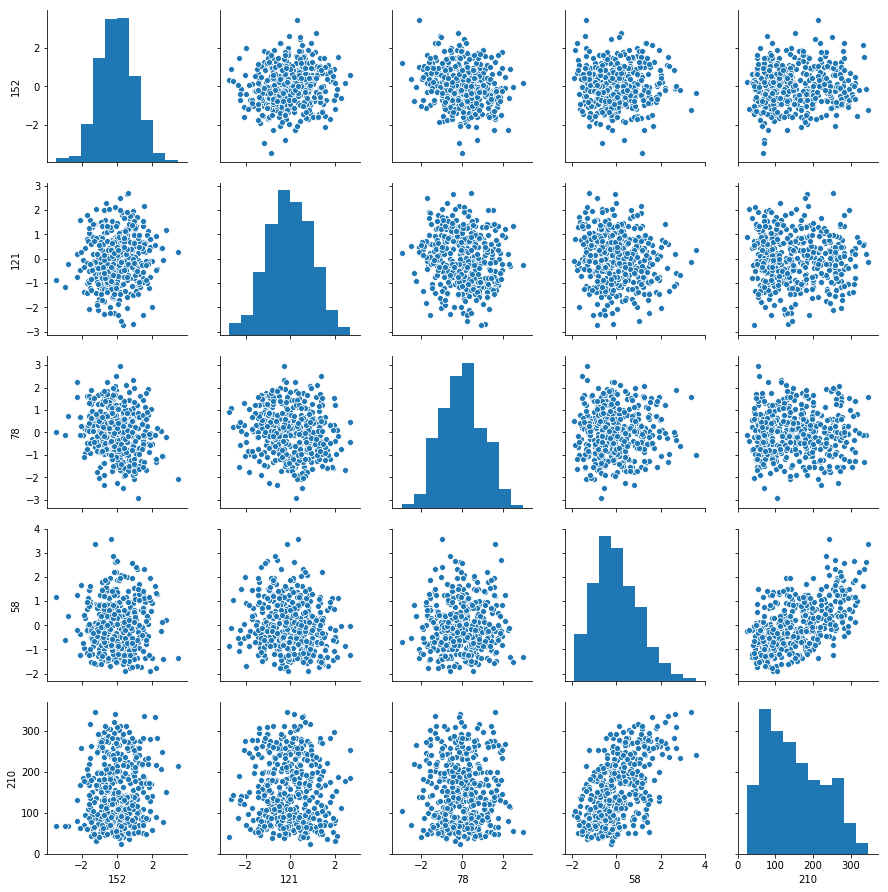

In [299]:
cols = list(choice(covariates.columns, 4, False))
cols.append(data.shape[1]-1)

sb.pairplot(data[data.columns[cols]])

On the diagonal, the histogram of the 5 series are plot. One can observes that the covariates are gaussians.

Out of the diagonal, the plot (i,j) represents the ith variable in function of the jth one. They doesn't seem to be related at all (Notice that the 5th variable is the score. So these 4 covariates doesn't seem to be related to the score.)

### Q3

In [300]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [301]:
X_train, X_test, Y_train, Y_test = train_test_split(covariates, scores, test_size = 0.2)

print("Train sample shape :", X_train.shape)
print("Test sample shape :", X_test.shape)

Train sample shape : (353, 210)
Test sample shape : (89, 210)


### Q4

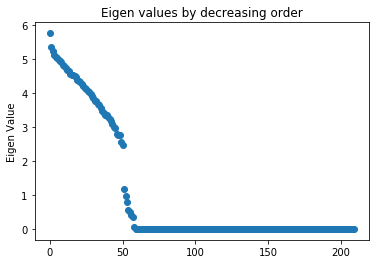

In [302]:
COV = np.cov(X_train.T) #Variable should be on a line not on a column (transpose)

eigen_values, eigen_vectors = np.linalg.eigh(COV)

sort_values = list(reversed(eigen_values))
sort_vectors = np.array(list(reversed(eigen_vectors)))


plt.scatter(range(210),sort_values)
plt.ylabel("Eigen Value")
plt.title("Eigen values by decreasing order")
plt.show()

It make sense to keep only the first PCA variables as the others are unsignificants. The information can be condense on the eigen vectors of the highest eigen values.

### Q5

In [303]:
V = sort_vectors[0:60]
X_train_PCA = np.dot(X_train, V.T)
linearRegPCA = LinearRegression().fit(X_train_PCA,Y_train)
linearReg = LinearRegression().fit(X_train,Y_train)

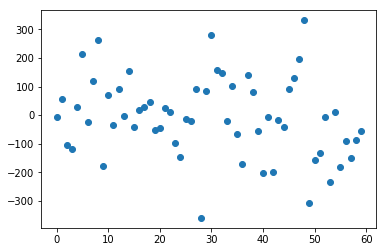

In [304]:
plt.plot(linearRegPCA.coef_, 'o')

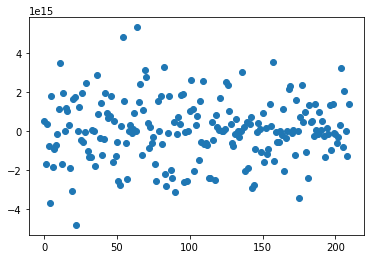

In [305]:
plt.plot(linearReg.coef_,"o")

### Q6

In [306]:
print("==========OLS==========")
print("Intercept :", linearReg.intercept_)
print()
print("=======PCA + OLS=======")
print("Intercept :", linearRegPCA.intercept_)
print()
print("Mean output value :", Y_train.mean())

==========OLS==========
Intercept : 151.24424575070822

=======PCA + OLS=======
Intercept : 152.7663624683645

Mean output value : 152.02549575070822


The intercepts are differents. They also aren't equal to the mean of Y for the train set. Indeed they are not centered and normalized.

In [307]:
X_train_PCA_norm = (X_train_PCA - X_train_PCA.mean(axis = 0))/(X_train_PCA.std(axis = 0))
PCANorm = LinearRegression().fit(X_train_PCA_norm,Y_train)

print(PCANorm.intercept_, ",",Y_train.mean(), "-> The intercept is equal to the mean output on the centered data.")

152.02549575070822 , 152.02549575070822 -> The intercept is equal to the mean output on the centered data.


### Q7

            ===========Without PCA=============
Determination coefficient R2 : -0.053509573421133716
Prediction risk: 5394.109998134085


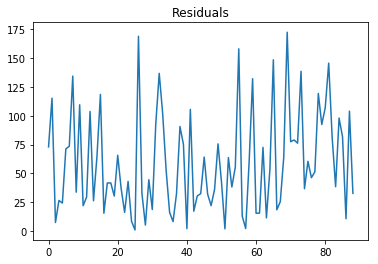


            ===========With PCA================
Determination coefficient R2 : 0.3327621073797732
Prediction risk: 3416.3473009826585


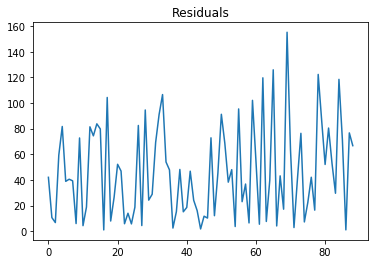

In [308]:
Y_pred = linearReg.predict(X_test)
Y_pred_PCA = linearRegPCA.predict(np.dot(X_test, V.T))

residuals = np.abs(Y_pred-Y_test)
residuals_PCA = np.abs(Y_pred_PCA - Y_test)

print("            ===========Without PCA=============")
print("Determination coefficient R2 :", linearReg.score(X_test, Y_test))
print("Prediction risk:", np.dot(residuals, residuals.T)/len(residuals))

plt.plot(range(len(Y_test)), residuals)
plt.title("Residuals")
plt.show()

print()
print("            ===========With PCA================")
print("Determination coefficient R2 :", linearRegPCA.score(np.dot(X_test, V.T), Y_test))
print("Prediction risk:", np.dot(residuals_PCA, residuals_PCA.T)/len(residuals))

plt.plot(range(len(Y_test)), residuals_PCA)
plt.title("Residuals")
plt.show()

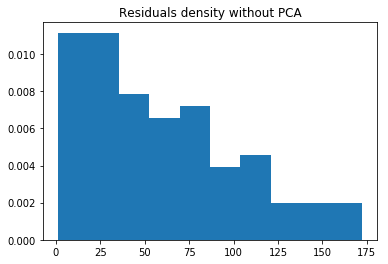

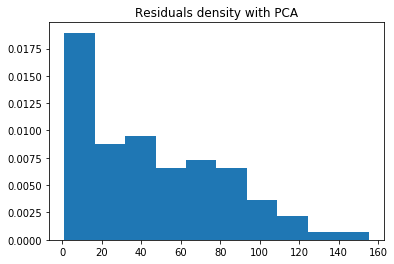

In [309]:
plt.hist(residuals, density =True)
plt.title("Residuals density without PCA")
plt.show()
plt.hist(residuals_PCA, density =True)
plt.title("Residuals density with PCA")
plt.show()

### Q8

In [310]:
from scipy.stats import norm
#Add a 1 columns to handle the intercept
X_train_aug = np.column_stack((np.ones((X_train.shape[0], 1 )), X_train))
p = X_train_aug.shape[1]
n = X_train_aug.shape[0]

resids = Y_train

variables_to_add = list(range(p))
variables_added = []

#Initializes to zeros all the tests/p_values. Costly in memory but more efficient to compute
tests = np.zeros((p,p))
p_values = np.zeros((p,p))

#The intercept is already a 'variable'
reg = LinearRegression(fit_intercept = False)

for k in range(p):
    resids_next = np.zeros((n,p))
    for var in variables_to_add:
        reg.fit(X_train_aug[:,[var]],resids)
        
        #store the rest for this variable
        resids_next[:,var] = resids - reg.predict(X_train_aug[:,[var]])
        #Compute sigma_2 (1/(n-1) sum(Yi-Ypredi)) times sn1_2 = xTx/n (in R) 
        sigma_x_snk_2 = np.sum(resids_next[:,var]**2)/(n-1)*n/np.sum(X_train_aug[:,var]**2)
        
        #we take the abs of the test directly
        tests[k, var] = np.sqrt(n) * np.abs(reg.coef_)/np.sqrt(sigma_x_snk_2)
        p_values[k, var] = 2*(1-norm.cdf(tests[k,var]))
    
    best_var = np.argmax(tests[k,:])
    variables_to_add.remove(best_var)
    variables_added.append(best_var)
    resids = resids_next[:,best_var]

### Q9

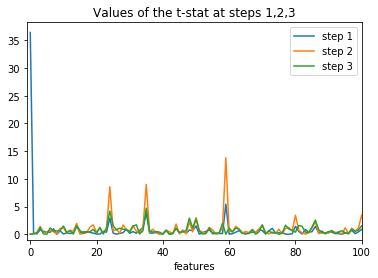

In [311]:
for k in range(3):
    plt.plot(np.arange(p),tests[k,:], '-',label = "step "+ str(k+1))
    plt.axis(xmin = -1,xmax = 100,ymin = -1)
plt.legend(loc=1)
plt.title("Values of the t-stat at steps 1,2,3")
plt.xlabel("features")
plt.show()

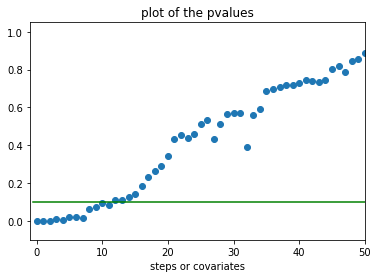

In [312]:
p_val = []
for (i,var) in enumerate(variables_added):
    p_val.append(p_values[i,var])

plt.plot(np.arange(p),p_val, 'o')
plt.plot([-0.5,50],[.1,.1],color = "green" )
plt.axis(xmin = -1,xmax = 50,ymin = -0.1)
plt.title("plot of the pvalues")
plt.xlabel("steps or covariates")
plt.show()

In [313]:
selected_variables = np.array(variables_added)[np.array(p_val)<.1]
print("Selected variables :" , selected_variables)

Selected variables : [  0  59 124 134 168  48  86 136  15 175  91  27]


### Q10

Determination coefficient R2 : 0.3681364950343454
Prediction risk: 3235.2257023380844


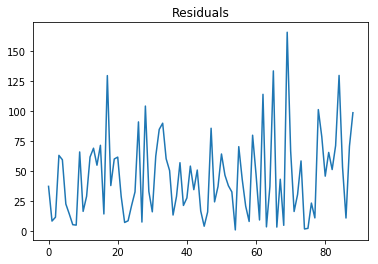

In [314]:
sel = selected_variables[selected_variables != 0]-1
X_train_forward = X_train[sel]


linearRegForward = LinearRegression().fit(X_train_forward, Y_train)


Y_pred_forward = linearRegForward.predict(X_test[sel])
residuals_forward = np.abs(Y_pred_forward-Y_test)

print("Determination coefficient R2 :", linearRegForward.score(X_test[sel], Y_test))
print("Prediction risk:", np.dot(residuals_forward, residuals_forward.T)/len(residuals_forward))

plt.plot(range(len(Y_test)), residuals_forward)
plt.title("Residuals")
plt.show()

Explication a ajouter

### Q11

In [315]:
n = X_train.shape[0]

sel = np.array(X_train.index)
np.random.shuffle(sel)

sels = []

for k in range(4):
    sels.append(sel[int((n)/4*k):int((n)/4*(k+1))])

X = []
Y = []

for k in range(4):
    X.append(X_train.loc[sels[k]])
    Y.append(Y_train[sels[k]])
    print(str(k+1)+"th set :", sels[k].shape[0], "lines.")

1th set : 88 lines.
2th set : 88 lines.
3th set : 88 lines.
4th set : 89 lines.


### Q12

In [316]:
from sklearn.linear_model import Ridge


alphas = [1e-15]+[i * 10**j for j in range(-5,3) for i in range(1,10)]
risk = np.zeros(len(alphas))
score = np.zeros(len(alphas))
for k in range(4):
    X_train_k = pd.concat([X[i] for i in range(4) if i != k ])
    Y_train_k = pd.concat([Y[i] for i in range(4) if i != k ])
    X_test_k = X[k]
    Y_test_k = Y[k]
    
    for i in range(len(alphas)):
        linearReg_k = Ridge(alphas[i]).fit(X_train_k, Y_train_k)
        risk[i] += np.sum((linearReg_k.predict(X_test_k) - Y_test_k)**2)/len(Y_test_k)
        score[i] += linearReg_k.score(X_test_k,Y_test_k)
        
    

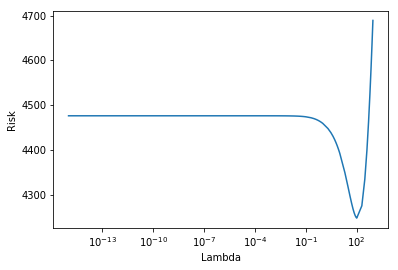

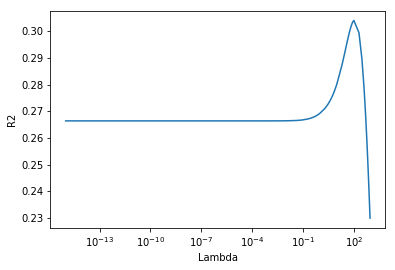

In [318]:
plt.plot(alphas, risk/4)
plt.xscale("log")
plt.ylabel("Risk")
plt.xlabel("Lambda")
plt.show()

plt.plot(alphas, score/4)
plt.xscale("log")
plt.ylabel("R2")
plt.xlabel("Lambda")
plt.show()

In [281]:


alpha = 1e-15
k = 1
X_train_k = pd.concat([X[i] for i in range(4) if i != k ])
Y_train_k = pd.concat([Y[i] for i in range(4) if i != k ])
X_test_k = X[k]
Y_test_k = Y[k]

xtrain = X_train
ytrain = Y_train

linearReg_k = Ridge(alpha).fit(xtrain, ytrain)
linearRegTest = LinearRegression().fit(xtrain, ytrain)
train = np.column_stack((np.ones((xtrain.shape[0], 1 )), xtrain))

linearReg_k2 = Ridge(alpha, fit_intercept = False).fit(train, ytrain)
linearRegTest2 = LinearRegression(fit_intercept = False).fit(train, ytrain)
params = np.dot(np.linalg.pinv(np.dot(train.T, train)), np.dot(train.T, ytrain))
    

In [282]:
xtest = X_test
ytest = Y_test

Y_pred_0 = params[0] + np.dot(xtest, params[1:])
Y_pred_1 = linearReg_k.predict(xtest)
Y_pred_2 = linearRegTest.predict(xtest)
test = np.column_stack((np.ones((xtest.shape[0], 1 )), xtest))
Y_pred_3 = linearReg_k2.predict(test)
Y_pred_4 = linearRegTest2.predict(test)

In [262]:
print("Y0 :",np.sum((Y_pred_0-ytest)**2)/len(ytest))
print("Y1 :",np.sum((Y_pred_1-ytest)**2)/len(ytest))
print("Y2 :",np.sum((Y_pred_2-ytest)**2)/len(ytest))
print("Y3 :",np.sum((Y_pred_3-ytest)**2)/len(ytest))
print("Y4 :",np.sum((Y_pred_4-ytest)**2)/len(ytest))

Y0 : 3872.996988397199
Y1 : 3872.996988397714
Y2 : 4904.231314026154
Y3 : 3872.996988397132
Y4 : 5134.285385026174


In [320]:
for k in range(50):
    xtrain, xtest, ytrain, ytest = train_test_split(covariates, scores, test_size = 0.2)
    xtest = xtrain 
    ytest=ytrain

    ridge = Ridge(1e-15).fit(xtrain, ytrain)
    linear = LinearRegression().fit(xtrain, ytrain)

    #a la main
    train = np.column_stack((np.ones((xtrain.shape[0], 1 )), xtrain))
    hand = np.dot(np.linalg.pinv(np.dot(train.T, train)), np.dot(train.T, ytrain))

    Y_pred_hand = hand[0] + np.dot(xtest, hand[1:])
    Y_pred_ridge = ridge.predict(xtest)
    Y_pred_linear = linear.predict(xtest)
    
    error_hand = np.sum((Y_pred_hand-ytest)**2)/len(ytest)
    error_ridge = np.sum((Y_pred_ridge-ytest)**2)/len(ytest)
    error_linear = np.sum((Y_pred_linear-ytest)**2)/len(ytest)
    
    print(error_hand, error_ridge, error_linear)
    if error_hand < error_ridge:
        if error_hand < error_linear:
            print("hand")
        else:
            print("linear")
    else:
        if error_ridge < error_linear:
            print("ridge")
        else:
            print("linear")
    print("--------------------------------------------")

2317.3084230415857 2317.3084230415457 5190.530519867265
ridge
--------------------------------------------
2512.4682932898486 2511.9129115391142 3719.873914796607
ridge
--------------------------------------------
2449.05985158549 2449.0270416859457 4103.292228402854
ridge
--------------------------------------------
2103.585575484516 2103.5767817129695 3063.854336316428
ridge
--------------------------------------------
2517.984264801546 2517.9842648015024 4022.2393513489783
ridge
--------------------------------------------
2507.8800470084816 2507.8658693328366 4069.317988257997
ridge
--------------------------------------------
2421.510067146712 2421.3365833725966 3483.0380267138207
ridge
--------------------------------------------
2627.901972367352 2627.617792672746 6552.137238680389
ridge
--------------------------------------------
2536.899666574207 2536.775311618251 3709.3157316741695
ridge
--------------------------------------------
2407.327595166344 2407.1832214249903 3792.4

### Q13

In [322]:
from sklearn.linear_model import LassoCV
LassoReg = LassoCV(cv = 4).fit(X_train,Y_train)

In [331]:
print("Choosen parameter :",LassoReg.alpha_)
print("Prediction risk :", np.sum((LassoReg.predict(X_test) - Y_test)**2)/len(Y_test))
print("R2 :", LassoReg.score(X_test, Y_test))

Choosen parameter : 5.038703738447229
Prediction risk : 2931.3252595206636
R2 : 0.427490498935976


### Q14

In [346]:
lasso_vars = [i for i in range(len(LassoReg.coef_)) if (LassoReg.coef_[i] != 0)]
train = np.column_stack((np.ones((X_train.shape[0], 1 )), X_train[lasso_vars]))
hand = np.dot(np.linalg.pinv(np.dot(train.T, train)), np.dot(train.T, ytrain))
OLSLasso = Ridge(1e-15).fit(X_train[lasso_vars], Y_train)

In [350]:
print("Prediction risk :",np.sum((OLSLasso.predict(X_test[lasso_vars]) - Y_test)**2)/len(Y_test))
print("R2 :", OLSLasso.score(X_test[lasso_vars], Y_test))
print(np.sum((hand[0] + np.dot(X_test[lasso_vars], hand[1:]) - Y_test)**2)/len(Y_test))

Prediction risk : 3179.093481466807
R2 : 0.3790995328822455
4622.099263702394
